In [18]:
# https://shapely.readthedocs.io/en/latest/manual.html#geometric-objects
# !pip3 install celery
# !pip3 install descartes
# !pip3 install matplotlib
# !pip3 install figures
# !pip3 install colour

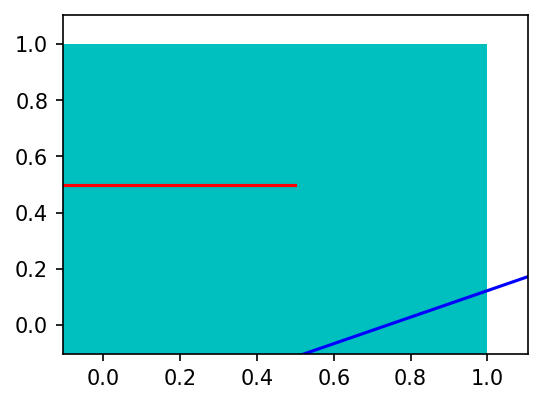

In [22]:
from numpy import asarray
import pylab
from shapely.geometry import Point, LineString, Polygon

polygon = Polygon(((-1.0, -1.0), (-1.0, 1.0), (1.0, 1.0), (1.0, -1.0)))

point_r = Point(-1.5, 1.2)
point_g = Point(-1.0, 1.0)
point_b = Point(-0.5, 0.5)

line_r = LineString(((-0.5, 0.5), (0.5, 0.5)))
line_g = LineString(((1.0, -1.0), (1.8, 0.5)))
line_b = LineString(((-1.8, -1.2), (1.8, 0.5)))

def plot_point(g, o, l):
    pylab.plot([g.x], [g.y], o, label=l)

def plot_line(g, o):
    a = asarray(g)
    pylab.plot(a[:,0], a[:,1], o)

def fill_polygon(g, o):
    a = asarray(g.exterior)
    pylab.fill(a[:,0], a[:,1], o, alpha=0.5)

def fill_multipolygon(g, o):
    for g in g.geoms:
        fill_polygon(g, o)

if __name__ == "__main__":
    from numpy import asarray
    import pylab
    
    fig = pylab.figure(1, figsize=(4, 3), dpi=150)
    #pylab.axis([-2.0, 2.0, -1.5, 1.5])
    pylab.axis('tight')

    a = asarray(polygon.exterior)
    pylab.fill(a[:,0], a[:,1], 'c')

    plot_point(point_r, 'ro', 'b')
    plot_point(point_g, 'go', 'c')
    plot_point(point_b, 'bo', 'd')

    plot_line(line_r, 'r')
    plot_line(line_g, 'g')
    plot_line(line_b, 'b')

    pylab.show()

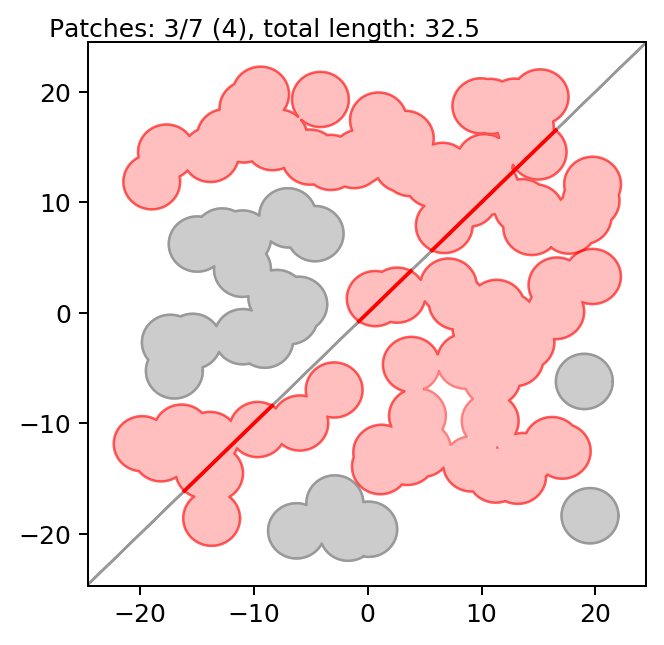

In [25]:
# intersect.py
#
# Demonstrate how Shapely can be used to analyze and plot the intersection of
# a trajectory and regions in space.

from functools import partial
import random

import pylab

from shapely.geometry import LineString, Point
from shapely.ops import unary_union

# Build patches as in dissolved.py
r = partial(random.uniform, -20.0, 20.0)
points = [Point(r(), r()) for i in range(100)]
spots = [p.buffer(2.5) for p in points]
patches = unary_union(spots)

# Represent the following geolocation parameters
#
# initial position: -25, -25
# heading: 45.0
# speed: 50*sqrt(2)
#
# as a line
vector = LineString(((-25.0, -25.0), (25.0, 25.0)))

# Find intercepted and missed patches. List the former so we can count them
# later
intercepts = [patch for patch in patches.geoms if vector.intersects(patch)]
misses = (patch for patch in patches.geoms if not vector.intersects(patch))

# Plot the intersection
intersection = vector.intersection(patches)
assert intersection.geom_type in ['MultiLineString']

if __name__ == "__main__":
    # Illustrate the results using matplotlib's pylab interface
    pylab.figure(num=None, figsize=(4, 4), dpi=180)
    
    # Plot the misses
    for spot in misses:
        x, y = spot.exterior.xy
        pylab.fill(x, y, color='#cccccc', aa=True) 
        pylab.plot(x, y, color='#999999', aa=True, lw=1.0)
    
        # Do the same for the holes of the patch
        for hole in spot.interiors:
            x, y = hole.xy
            pylab.fill(x, y, color='#ffffff', aa=True) 
            pylab.plot(x, y, color='#999999', aa=True, lw=1.0)
    
    # Plot the intercepts
    for spot in intercepts:
        x, y = spot.exterior.xy
        pylab.fill(x, y, color='red', alpha=0.25, aa=True) 
        pylab.plot(x, y, color='red', alpha=0.5, aa=True, lw=1.0)
    
        # Do the same for the holes of the patch
        for hole in spot.interiors:
            x, y = hole.xy
            pylab.fill(x, y, color='#ffffff', aa=True) 
            pylab.plot(x, y, color='red', alpha=0.5, aa=True, lw=1.0)
    
    # Draw the projected trajectory
    pylab.arrow(-25, -25, 50, 50, color='#999999', aa=True,
        head_width=1.0, head_length=1.0)
    
    for segment in intersection.geoms:
        x, y = segment.xy
        pylab.plot(x, y, color='red', aa=True, lw=1.5)
    
    # Write the number of patches and the total patch area to the figure
    pylab.text(-28, 25, 
        "Patches: %d/%d (%d), total length: %.1f" \
         % (len(intercepts), len(patches.geoms), 
            len(intersection.geoms), intersection.length))
    
    pylab.savefig('intersect.png')

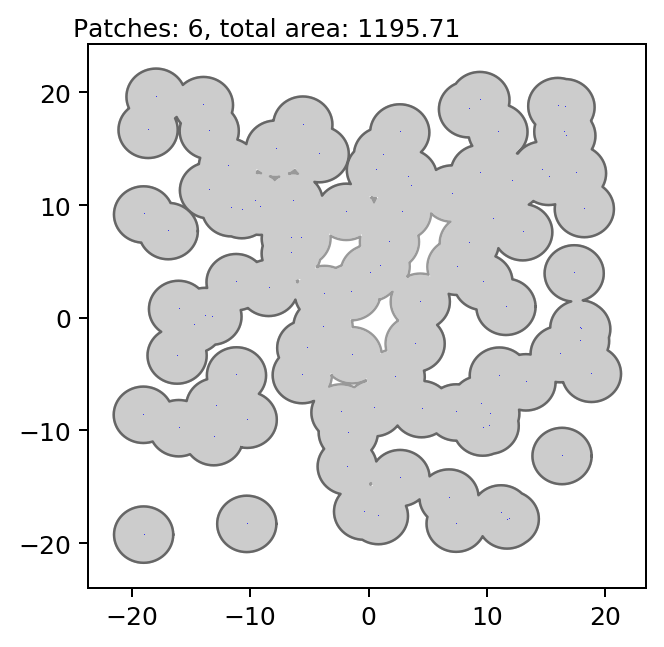

In [26]:
# dissolve.py
#
# Demonstrate how Shapely can be used to build up a collection of patches by 
# dissolving circular regions and how Shapely supports plotting of the results.

from functools import partial
import random

import pylab

from shapely.geometry import Point
from shapely.ops import unary_union

# Use a partial function to make 100 points uniformly distributed in a 40x40 
# box centered on 0,0.
r = partial(random.uniform, -20.0, 20.0)
points = [Point(r(), r()) for i in range(100)]

# Buffer the points, producing 100 polygon spots
spots = [p.buffer(2.5) for p in points]

# Perform a unary union of the polygon spots, dissolving them into a
# collection of polygon patches
patches = unary_union(spots)

if __name__ == "__main__":
    # Illustrate the results using matplotlib's pylab interface
    pylab.figure(num=None, figsize=(4, 4), dpi=180)
    
    for patch in patches.geoms:
        assert patch.geom_type in ['Polygon']
        assert patch.is_valid
    
        # Fill and outline each patch
        x, y = patch.exterior.xy
        pylab.fill(x, y, color='#cccccc', aa=True) 
        pylab.plot(x, y, color='#666666', aa=True, lw=1.0)
    
        # Do the same for the holes of the patch
        for hole in patch.interiors:
            x, y = hole.xy
            pylab.fill(x, y, color='#ffffff', aa=True) 
            pylab.plot(x, y, color='#999999', aa=True, lw=1.0)
    
    # Plot the original points
    pylab.plot([p.x for p in points], [p.y for p in points], 'b,', alpha=0.75)
    
    # Write the number of patches and the total patch area to the figure
    pylab.text(-25, 25, 
        "Patches: %d, total area: %.2f" % (len(patches.geoms), patches.area))
    
    pylab.savefig('dissolve.png')